# Gaussian Processes Regression

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import gaussian_process as GP
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, cdist, squareform
np.random.seed(6)

In [2]:
# First define input test points at which to evaluate the sampled functions
X_test = np.arange(-5, 5, 0.005)[:, np.newaxis] # in general these can be > 1d, hence the extra axis.

In [3]:
# Set the parameters for each kernel.
sigma_f_sq = 1 # Linear
l = 1  # Squared Exponential
alpha = 1 # RationalQuadratic
f = 0.5 # Periodic

In [4]:
# Instantiate GPs using each of these kernels.
gps = {'Linear': GP.GPR(kernel=GP.Linear(sigma_f_sq)), 
       'SquaredExponential': GP.GPR(kernel=GP.SquaredExponential(l)),
       'RationalQuadratic': GP.GPR(kernel=GP.RationalQuadratic(f,alpha)),
       'Periodic': GP.GPR(kernel=GP.Periodic(f))}

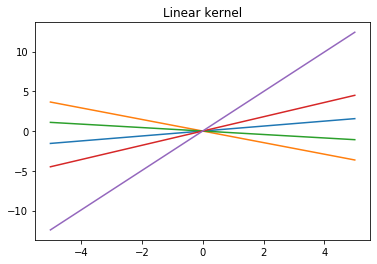

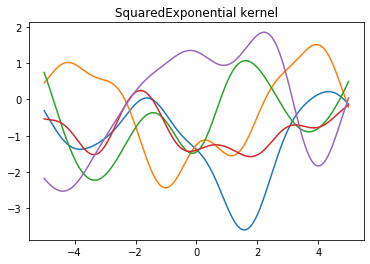

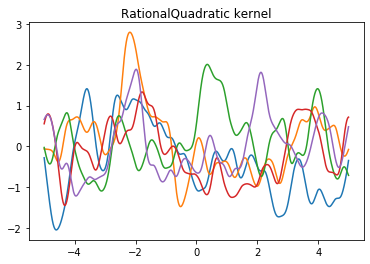

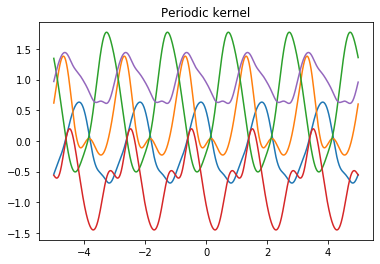

In [5]:
# Plot samples from the prior of each GP
for name, gp in gps.items():
    y_samples = gp.sample_prior(X_test, n_samples=5)
    plt.plot(X_test, y_samples)
    plt.title('{} kernel'.format(name))
    plt.show()

In [28]:
# Define GP
gp = gps['SquaredExponential']

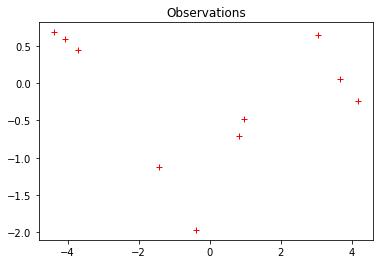

In [29]:
# Generate observations using a sample drawn from the prior.
X_train = np.sort(np.random.uniform(-5, 5, 10))[:, np.newaxis]
y_train = gp.sample_prior(X_train)
y_train = y_train[:, 0]  # Only one sample

plt.plot(X_train[:, 0], y_train, 'r+')
plt.title('Observations')
plt.show()

In [30]:
# Generate posterior samples, saving the posterior mean and covariance too.
f_star_samples, f_star_mean, f_star_covar = gp.sample_posterior(X_train, y_train, X_test, n_samples=100)

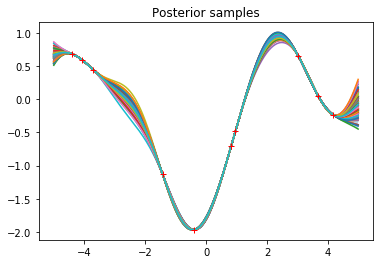

In [31]:
# Plot poterior mean and 95% confidence interval.
pointwise_variances = f_star_covar.diagonal()
error = 1.96 * np.sqrt(pointwise_variances)
plt.plot(X_test, f_star_mean, 'b')
plt.fill_between(X_test[:, 0], f_star_mean - error, f_star_mean + error, alpha=0.3)

# Plot samples from posterior
plt.plot(X_test, f_star_samples)

# Also plot our observations for comparison
plt.plot(X_train[:, 0], y_train, 'r+')

plt.title('Posterior samples')
plt.show()

In [32]:
success = gp.optimize(X_train, y_train)
if success:
    print('MAP estimate of theta is {}. Maximised log marginal liklehihood is {}.'.format(gp.kernel.theta_MAP, gp.max_log_marginal_likelihood_value))
else:
    print('Optimization failed. Try setting different initial value of theta.')

MAP estimate of theta is [1.34434519]. Maximised log marginal liklehihood is -2.4121092693916317.


In [33]:
# Create coordinates in parameter space at which to evaluate the lml.
length_scales = np.linspace(0.8, 1.4, 100)
noise_variance = np.linspace(1e-12, 1e-2, 100)
X, Y = np.meshgrid(length_scales, noise_variance)

In [34]:
# Evaluate the lml at these coordinates.
Z = np.array(list(map(lambda x: gp.log_marginal_likelihood(X_train, y_train, theta=[x[0]], noise_var=x[1]), list(zip(X.ravel(), Y.ravel())))))
Z = Z.reshape((X.shape))

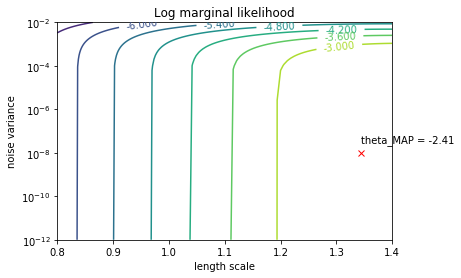

In [35]:
# Plot the contours.
fig, ax = plt.subplots()
ax.set_yscale('log')
levels = np.arange(-3, 3, 0.25)
CS = ax.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)
plt.plot(gp.kernel.theta_MAP[0], gp.noise_var, color='red', marker='x')
plt.annotate('theta_MAP = {:.2f}'.format(
    gp.max_log_marginal_likelihood_value), xy=(gp.kernel.theta_MAP[0], gp.noise_var + 2e-8))
plt.title('Log marginal likelihood')
plt.xlabel('length scale')
plt.ylabel('noise variance')
plt.show()

In [36]:
f_star_samples, f_star_mean, f_star_covar = gp.sample_posterior(X_train, y_train, X_test, n_samples=100)

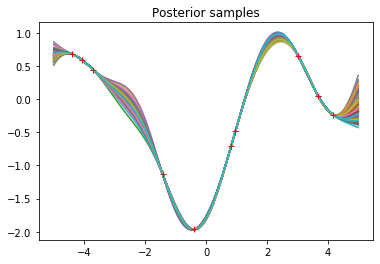

In [37]:
# Plot poterior mean and 95% confidence interval.
pointwise_variances = f_star_covar.diagonal()
error = 1.96 * np.sqrt(pointwise_variances)
plt.plot(X_test, f_star_mean, 'b')
plt.fill_between(X_test[:, 0], f_star_mean - error, f_star_mean + error, alpha=0.3)

# Plot samples from posterior
plt.plot(X_test, f_star_samples)

# Also plot our observations for comparison
plt.plot(X_train[:, 0], y_train, 'r+')

plt.title('Posterior samples')
plt.show()

# Data

In [162]:
input_file="rw_log_views.csv"
df=pd.read_csv(input_file, sep=";",decimal=",")

df['date']=df['date'].astype('datetime64[ns]') 
df=df.set_index("date", drop=True)

y = df.iloc[df.index>"2016", 0].ravel().reshape(-1,1)
X = np.arange(y.shape[0]).reshape(-1,1)

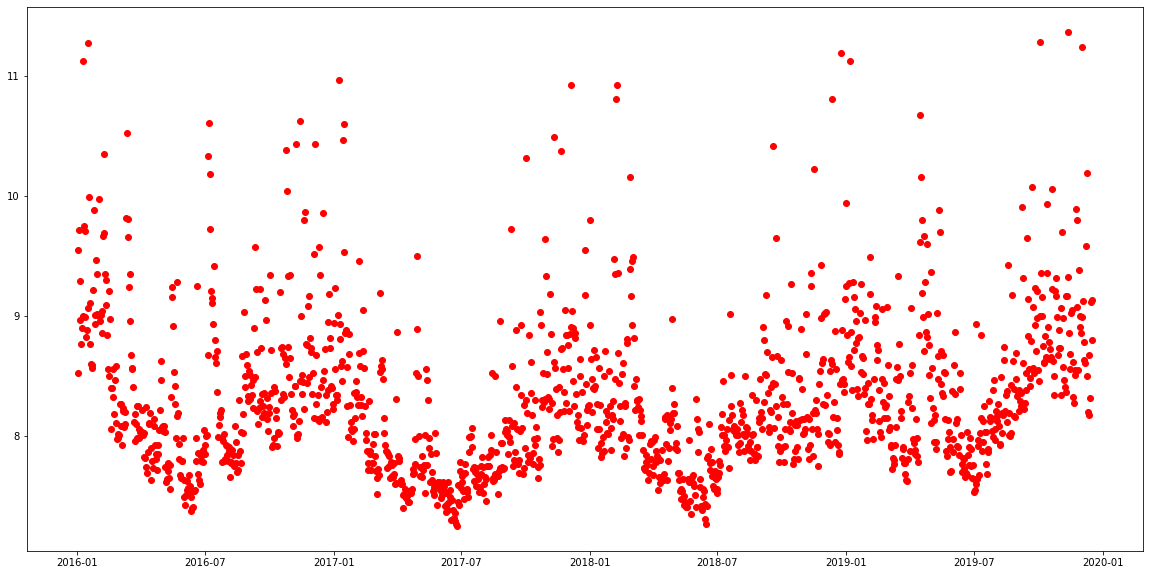

In [163]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(df.iloc[df.index>"2016"], 'ro')

# scikit

In [84]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

In [85]:
kernel = ConstantKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1)

In [86]:
GPR = gaussian_process.GaussianProcessRegressor(kernel=kernel)
GPR.fit(X, y)



GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [88]:
gp.kernel_

8.14**2 + Matern(length_scale=14.1, nu=1.5) + WhiteKernel(noise_level=0.184)

In [159]:
X_pred = np.linspace(0, X.shape[0]+100).reshape(-1,1)
y_pred, sigma = GPR.predict(X_pred, return_std=True)
error = (1.96 * sigma).reshape(-1,1)

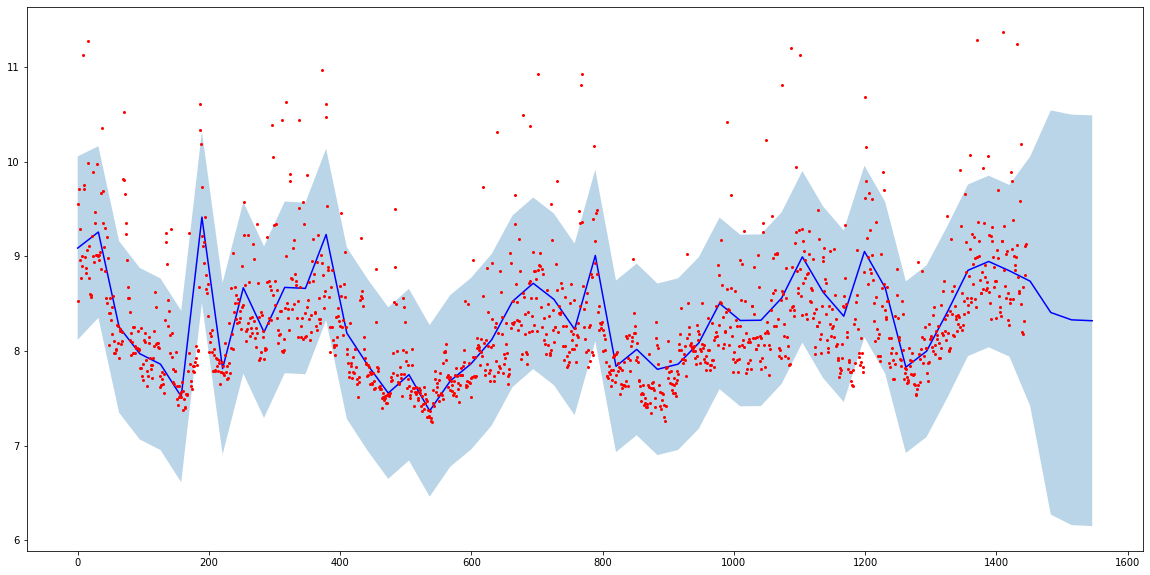

In [160]:
plt.plot(X_pred, y_pred, 'b')
plt.fill_between(X_pred.ravel(), (y_pred - error).ravel(), (y_pred + error).ravel(), alpha=0.3)

plt.plot(X, y, 'ro', ms=2)

# GPflow

In [167]:
import GPflow

ModuleNotFoundError: No module named 'GPflow'

In [164]:
Y = y.reshape(-1,1)
k = GPflow.kernels.Matern32(1, variance=1, lengthscales=1.2)

NameError: name 'GPflow' is not defined

In [ ]:
m = GPflow.gpr.GPR(X, Y, kern=k)

In [ ]:
m.likelihood.variance = 0.01

In [ ]:
m.optimize()

In [ ]:
m

In [ ]:
m.kern.variance.prior = GPflow.priors.Gamma(1,0.1)
m.kern.lengthscales.prior = GPflow.priors.Gamma(1,0.1)

In [ ]:
m.likelihood.variance = 0.1
m.likelihood.variance.fixed = True
m.optimize()

In [ ]:
print(m)

In [ ]:
l = GPflow.likelihoods.StudentT()
m = GPflow.gpmc.GPMC(X, Y, kern=k, likelihood=l)
m.kern.variance.prior = GPflow.priors.Gamma(1,1)
m.kern.lengthscales.prior = GPflow.priors.Gamma(1,1)

In [ ]:
trace = m.sample(1000, verbose=True, epsilon=0.03, Lmax=15)

In [ ]:
parameter_samples = m.get_samples_df(trace)
 
for col in parameter_samples.columns.sort_values()[1:]:
parameter_samples[col].hist(label=col.split('.')[-1], alpha=0.4, bins=15)

In [ ]:
realizations = []
for sample in trace[-100:]:
m.set_state(sample)
realizations.append(m.predict_f_samples(xx, 1).squeeze())
realizations = np.vstack(realizations)

# PyMC3

In [168]:
import pymc3 as pm
import theano.tensor as tt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [178]:
with pm.Model() as gp_fit:
    rho = pm.Gamma('ρ', 1, 1)
    eta = pm.Gamma('η', 1, 1)
    K = eta * pm.gp.cov.Matern32(1, rho)

In [179]:
with gp_fit:
    M = pm.gp.mean.Zero()
    sigma = pm.HalfCauchy('σ', 2.5)

In [187]:
with gp_fit:
    y_obs = pm.gp.Latent('y_obs', mean_func=M, cov_func=K, sigma=sigma, observed={'X':X, 'Y':Y})

TypeError: __init__() got multiple values for argument 'mean_func'

In [186]:
help(pm.gp.GaussianProcess)

AttributeError: module 'pymc3.gp' has no attribute 'GaussianProcess'

In [ ]:
with gp_fit:
    trace = pm.sample(2000, n_init=20000)

In [ ]:
pm.traceplot(trace[-1000:], varnames=[rho, sigma, eta]);

In [ ]:
Z = np.linspace(-6, 6, 100).reshape(-1, 1)
with gp_fit:
    gp_samples = pm.gp.sample_gp(trace[1000:], y_obs, Z, samples=50)